In [1]:
# this is copy of idfglove.ipynb
# do it again, but build a model out of the uncased 
# file glove.42B.300d.txt
# using the Glove vocab

# standard library
import time
import json
import re
import numpy as np
import urllib

import sentence_transformers
from sentence_transformers.models.tokenizer import WhitespaceTokenizer
from sentence_transformers.models import WordEmbeddings

from scipy.linalg import norm

import matplotlib.pyplot as plt

# Read in data

In [2]:
# dirname = "/Users/cschmidt/delomore/delomore-parse-output/output/"

In [3]:
# alljson = { "collections" : {},
#             "products" : {},
#             "homepage" : [],
#             "about" : [],
#             "pages" : [],
#             "blogs" : [],
#           }

In [4]:
# queryfile = "/Users/cschmidt/otherrepos/delomore-dataset/query-domains.tsv"
# querydomain = open(queryfile, "rt").readlines()
# querydomain = [l.rstrip().split("\t") for l in querydomain]

# # get the set of display domains
# gooddomains = set()

# for (query, displaydomain, domain) in querydomain:
#     gooddomains.add(displaydomain)
    
# print(len(gooddomains))

# Get the vocab from the Glove model directly

In [5]:
# this is the model that doesn't consider case of words
# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

glovefile = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.txt"

start_time = time.time()
vocab = [getinitialword(l) for l in open(glovefile, 'rt').readlines()]

vocabSet = set(vocab)
print(len(vocab))

# no dupes this time
print(len(vocabSet))

print("time:", time.time() - start_time)

1917494
1917494
time: 32.60562610626221


In [6]:
# filter out some of the words with a . in them,
# including a bunch of number related cruft 

# lets include things like 2,890.00
isnumber = re.compile("^[0-9.,:-]+$")
justdigits = re.compile("^[0-9]+$")

def isNumber(s):
    return isnumber.search(s) != None

def isInteger(s):
    return justdigits.search(s) != None

In [7]:
# how many cases have a period just at the end
# and the word without it is in the vocab
def isbad(s):
    firstdot = s.find(".")
    # no dot
    if firstdot == -1:
        return False
    # first dot isn't last character
    if firstdot != len(s)-1:
        return False
    # is bad if the word without it is in vocab
    return s[:firstdot] in vocab

badwords = set()
integers = set()
numbers = set()
otherdot = set()
for v in vocab:
        
        if isNumber(v):
            
            # lets keep the integers
            if isInteger(v):
                integers.add(v)
            else:
                # but lose the crufty numbers
                numbers.add(v)
        else:
            
            if isbad(v):
                badwords.add(v)
            else:
                if "." in v:
                    otherdot.add(v)
print("bad:",len(badwords))
print("integers:",len(integers))
print("numbers:",len(numbers))
print("other:",len(otherdot))

bad: 4962
integers: 65814
numbers: 255305
other: 74555


In [9]:
list(integers)[:10]

['13642',
 '14458',
 '53549',
 '54971',
 '26380',
 '63032',
 '6670',
 '32571',
 '10338',
 '1015213']

In [10]:
list(numbers)[:10]

['23:16:54',
 '00:15:33',
 ':18.8',
 '06:28:31',
 '17:54:58',
 '19,052',
 '106-07',
 '46-47',
 '7.36',
 '19:45:17']

In [11]:
# keep these
list(otherdot)[:10]

['infoplist.strings',
 'j.w.m.',
 'weeks.â',
 'yahoo.it',
 'accounts.i',
 'freedentalguide.com',
 'xxx.xxx.xxx.xxx',
 'lww4.htm',
 'moron.nl',
 'basement.org']

In [12]:
toskip = badwords | numbers
print(len(toskip))

260267


In [13]:
print("piece." in toskip)
print("quality." in toskip)
print("interior." in toskip) 

True
True
True


In [15]:
glovefilefiltered = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.filtered.txt"

# filter out the vectors for the words in toskip
kept = 0
filtered = 0

start_time = time.time()
with open(glovefilefiltered, "wt") as out:
    for l in open(glovefile, 'rt'):
        v = getinitialword(l)
        if v not in toskip:
            kept += 1 
            out.write(l)
        else:
            filtered += 1
            
print("time:", kept, filtered, time.time() - start_time)

time: 1657227 260267 10.859287023544312


In [16]:
# Load in the filtered text file, and make a tokenizer
# covert to the right internal format
# these embeddings are all lower case, so 
# have the tokenizer convert to lower case
model = WordEmbeddings.from_text_file(glovefilefiltered,tokenizer=WhitespaceTokenizer(do_lower_case=True))

Load Word Embeddings: 1657227Embeddings [02:21, 11677.17Embeddings/s]


In [17]:
# and dump it to disk
savedmodel = "/Users/cschmidt/otherrepos/idf-glove/glove/weightedoutput42"
model.save(savedmodel)

In [18]:
# redo vocab with filtering
start_time = time.time()
vocab = [getinitialword(l) for l in open(glovefilefiltered, 'rt').readlines()]

vocabSet = set(vocab)
print(len(vocab))
print(len(vocabSet))

print("time:", vocab, vocabSet, time.time() - start_time)

1657227
1657227
time: 18.87205195426941


# Get our Glove vocabulary

In [19]:
# augment this with our padding token that is in the tokenizer
tokenvocab = ["PADDING_TOKEN"] + vocab

In [20]:
# given the index in vocab, give us the words back
idx2word = { idx: w for (idx,w) in enumerate(tokenvocab) }
print(len(idx2word))

1657228


In [21]:
# can load it in directly
# note that it ignores stopwords
tokenizer = WhitespaceTokenizer().load(savedmodel)

In [22]:
# tokenize with our WhitespaceTokenizer, 
# but then return the actual words in a list
def tokenizeWords(s):
    return [idx2word[idx] for idx in tokenizer.tokenize(s)]

In [23]:
words = tokenizeWords("cow white")
print(words)
# stop words dissappear
words = tokenizeWords("the cow is white")
print(words)
# converts to lower case, drops punctuation
words = tokenizeWords("the Cow is white!")
print(words)

['cow', 'white']
['cow', 'white']
['cow', 'white']


In [27]:
# you do end up with some . characters in the vocab
# now have filtered some of these out
tokenizeWords("50 beanie package. a.m. 7.36")

['50', 'beanie', 'package', 'a.m.']

In [28]:
tokenizeWords("8.5")

[]

In [26]:
# compute our idf term, 
# for just those words in the vocabSet
# add 1 so still works if no values ??
# idf = { w : np.log(N/c) for (w,c) in wikidf.items() if w in vocabSet}
# len(idf)

In [29]:
# save clean to a file so we can compute information gain

# note that collections just have an 'og:title' and 'product-handles'

# output a single line, with space separated unique words
# skip if no words (that are in the vocab)
def getTokenizedText(d, out, row):
    
    text = ""
    
    for field in ["og:title", "og:site_name", "og:description"]:
        if field in d:

            # is occasionally a list, just use first then 
            if type(d[field]) == list:
                text += d[field][0] + " "
            else:
                text += d[field] + " "
    
    # eliminate duplicates, ends up in arbitrary order
    words = list(set(tokenizeWords(text)))
    
    # we want to generate pairs, so ignore ones with a single word
    if len(words) > 1:
        # space separate the words
        words = " ".join(words)
        # tab between row and words
        # out.write(str(row) + "\t" + text + "\n")
        out.write(str(row) + "\t" + words + "\n")
        # success so advance to next row
        return row + 1
    else:
        return row
    
start_time = time.time()

# directory for input data
dirname = "/Users/cschmidt/delomore/delomore-parse-output/output/"
row = 0

# just save in this repo
out = open("cleanwords.filtered.tsv", "wt")

# Use each page as a document here
# 00000 to 14222
for chunk in range(14223):
    
    if chunk % 100 == 0:
        print(chunk, time.time() - start_time)
    
    chunkname = str(chunk).rjust(5, '0') + ".tsv"

    filename = dirname + chunkname
    data = [l.rstrip().split("\t") for l in open(filename, 'rt').readlines()]    

    for domain,displaydomain,url,alljson in data:

        # convert to json
        j = json.loads(alljson)

        # are 4 possible kinds of pages to use
        if "about" in j:
            # is a possibly empty list
            for d in j["about"]:
                row = getTokenizedText(d, out, row)

        # note that collections just have an 'og:title' and 'product-handles'
        if "collections" in j:
            # is a dict with handles
            for handle, d in j["collections"].items():
                row = getTokenizedText(d, out, row)

        # has handles
        if "products" in j:
            # is a dict with handles
            for handle, d in j["products"].items():
                row = getTokenizedText(d, out, row)

        # has handles
        if "homepage" in j:
            # is a possibly empty list
            for d in j["homepage"]:
                row = getTokenizedText(d, out, row)

out.close()

0 0.0027091503143310547
100 20.430618047714233
200 41.83625411987305
300 60.65954113006592
400 82.61731910705566
500 104.86676716804504
600 127.89059615135193
700 148.06602907180786
800 170.23068809509277
900 190.79873204231262
1000 209.79683804512024
1100 228.79774403572083
1200 247.48914408683777
1300 266.4047701358795
1400 286.63281416893005
1500 308.7200610637665
1600 328.9879729747772
1700 349.9434971809387
1800 370.57430624961853
1900 390.8628239631653
2000 411.28292417526245
2100 433.6215569972992
2200 453.4350321292877
2300 473.76387906074524
2400 493.9031460285187
2500 514.5479071140289
2600 535.0809600353241
2700 555.1044640541077
2800 575.500785112381
2900 597.0536060333252
3000 617.7861762046814
3100 637.6052160263062
3200 657.8709189891815
3300 679.0987811088562
3400 700.4131379127502
3500 721.0105049610138
3600 740.8786859512329
3700 761.38858294487
3800 781.3772020339966
3900 800.529176235199
4000 821.0987939834595
4100 842.0032362937927
4200 863.7337129116058
4300 886.2

In [ ]:
# stopped here

In [ ]:
# wc cleanwords.tsv
# 62,587,173 1,658,580,366 11711434739 cleanwords.tsv

In [182]:
print(doccnt)
print(len(wordcnt))

64886566
1305349


In [186]:
# ok, so how many of thoese words are in vocab
# oh, the tokenizer drops all those words not in in vocab

# only keep those in at least 2 documents
# use our local doccnt
idf2 = { w : np.log(doccnt/c) for (w,c) in wordcnt.items() if c >= 2}

mywordset = set(wordcnt2)
print(len(mywordset))
# we can also use the df from idf that are also in vocab
either = mywordset | (set(idf.keys()) & vocabSet)
print(len(either))
print()

print("idf2:", len(idf2))
# now supplement with any values of idf that aren't already in idf2
# however, we want to use the existing value if it is there
for (w,v) in idf.items():
    if w not in idf2:
        idf2[w] = v
print("after idf2:", len(idf2))

assert len(idf2) == len(either)

1116700
1308084

idf2: 1116700
after idf2: 1308084


In [188]:
# the duplicate row donsn't have a weight, so won't end up in file
duplicate = "����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������"
duplicate in idf2

False

In [212]:
# lets output our idf2 values while we're at it
sortedidf2 = sorted([(v,w) for (w,v) in idf2.items()], reverse=True)

In [214]:
# and save to the disk
with open("/Users/cschmidt/otherrepos/idf-glove/glove/idf2.tsv", "wt") as out:
    for v,w in sortedidf2:
        out.write(str(v) + "\t" + w + "\n")

In [22]:
# load it back in, so we can try clipping values
sortedidf2 = []
justscores = []
with open("/Users/cschmidt/otherrepos/idf-glove/glove/idf2.tsv", "rt") as f:
    for line in f:
        idfval, word = line.rstrip().split("\t")
        sortedidf2.append((float(idfval), word))
        justscores.append(float(idfval))
idf2 = { w : s for (s,w) in sortedidf2}

In [4]:
sample = [s for i,s in enumerate(justscores) if i%100 == 0]
print(len(sample))

13081


In [28]:
len(idf2) - 1200000

108084

In [14]:
# see some values 
for i in range(len(sortedidf2)):
    if i % 20000 == 0:
        print(i, sortedidf2[i])

0 (17.29500398431037, '￡')
20000 (17.29500398431037, 'kearns')
40000 (17.29500398431037, 'Venao')
60000 (17.29500398431037, 'Morganthaler')
80000 (17.29500398431037, 'Durdy')
100000 (17.29500398431037, '4L4')
120000 (16.889538876202206, 'rerip')
140000 (16.889538876202206, 'Woollam')
160000 (16.889538876202206, 'Laelaps')
180000 (16.889538876202206, 'Adanson')
200000 (16.601856803750422, 'road.It')
220000 (16.601856803750422, 'Sixty-second')
240000 (16.601856803750422, 'CuteCircuit')
260000 (16.378713252436214, 'table.If')
280000 (16.378713252436214, 'Rainbowbrite')
300000 (16.378713252436214, '76.35')
320000 (16.19639169564226, 'bandmember')
340000 (16.19639169564226, 'Bokeem')
360000 (16.042241015815, 'beta-blockers')
380000 (16.042241015815, '68815')
400000 (15.908709623190479, 'Pelléas')
420000 (15.790926587534095, 'mid-1968')
440000 (15.790926587534095, '30297')
460000 (15.685566071876268, 'Cober')
480000 (15.590255892071944, 'Gizmoz')
500000 (15.503244515082315, 'Folkes')
520000 

In [6]:
# want to clip the very uncommon ones to the same value, so they don't 
# dominate the mid range terms
max(sample)

17.29500398431037

11.24173903629694


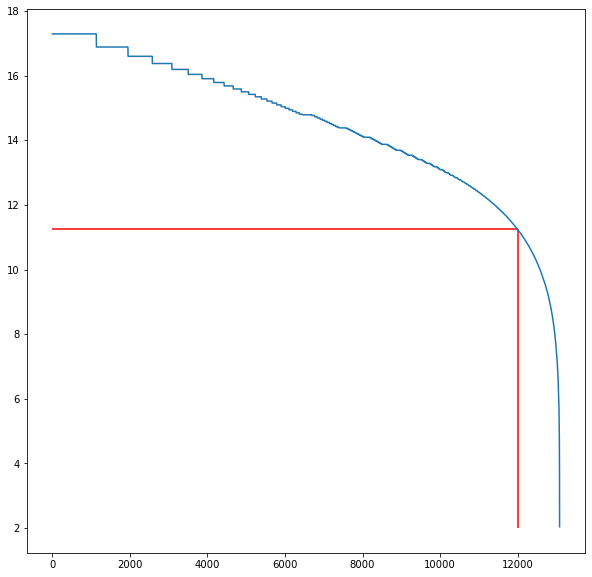

In [23]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(sample)
maxval = justscores[1200000]
print(maxval)
plt.vlines(x=12000,ymin=2, ymax=maxval, color="red")
plt.hlines(y=maxval,xmin=0, xmax=12000, color="red")

In [24]:
# might as well scale it so the max is 1.0 while we're at it
sortedidf3 = [(min(idfval,maxval)/maxval, w) for idfval,w in sortedidf2]
idf3 = { w : s for (s,w) in sortedidf3}
justscores = [s for (s,w) in sortedidf3]

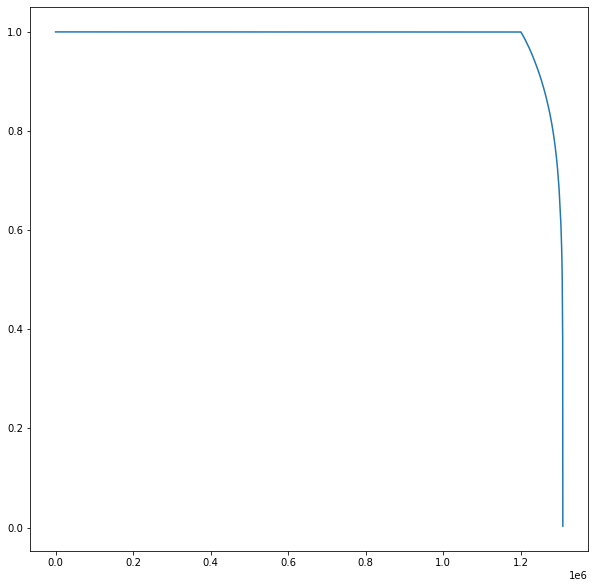

In [25]:
# this makes it clear it is about downweighting common words
# not making the more obscure stuff super important
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(justscores)
# maxval = justscores[1000000]
# print(maxval)
# plt.vlines(x=10000,ymin=2, ymax=maxval, color="red")
# plt.hlines(y=maxval,xmin=0, xmax=10000, color="red")

In [51]:
# now update our vectors file, 
# only keeping those rows in idf3,
# and multiplying each row by the idf value

glovefile =   "/Users/cschmidt/otherrepos/idf-glove/glove/glove.840B.300d.txt"
weightedout = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.840B.300d.weighted.txt"

# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

out = open(weightedout, "wt")

written = 0

start_time = time.time()
for line in open(glovefile, 'rt'):
    # this will be a bit faster, since most won't be in idf3
    gw = getinitialword(line)
    # only keep if have a valid weight
    if gw in idf3:
        vec = line.rstrip().split(" ")
        assert vec[0] == gw
        # drop the word
        vec = vec[1:]
        vec = np.array([float(x) for x in vec])
        # need to normalize
        vec /= norm(vec)
        # and multiply by idf3
        vec *= idf3[gw]
        out.write(gw + " " + " ".join([str(a) for a in vec]) + "\n")
        written += 1
        
print("time:", written, time.time() - start_time)
out.close()

time: 1308084 471.6110429763794


In [52]:
# covert to the right internal format
model = WordEmbeddings.from_text_file(weightedout)

Load Word Embeddings: 1308084Embeddings [03:17, 6622.58Embeddings/s]


In [53]:
# and dump it to disk
model.save("/Users/cschmidt/otherrepos/idf-glove/glove/weightedoutput")

In [54]:
print(idf3["weighted"])
print(idf3["blanket"])

0.6015102961325726
0.4681569843589681


In [57]:
# just look at an example
test = ["Bearaby",
"weighted",
"blanket",
"made",
"without",
"artificial",
"fillers",
"or",
"synthetic",
"fabrics",
"Naturally",
"heavy",
"cooling",
"and",
"hand-knit",
"with",
"organic",
"materials",
"Buy",
"weighted",
"blanket",
"now"]
        
for w in test:
    print(w, idf3.get(w,0.0))

Bearaby 0.0
weighted 0.6015102961325726
blanket 0.4681569843589681
made 0.142383046559281
without 0.21456753897446318
artificial 0.49430935445294394
fillers 0.6047332018048627
or 0.10244944076170853
synthetic 0.4641162106970325
fabrics 0.4135655872428576
Naturally 0.5281091853425119
heavy 0.39697307167562434
cooling 0.5129785034263893
and 0.02363397877630451
hand-knit 0.7848104235398403
with 0.05770230716883812
organic 0.3493871347665926
materials 0.3780104508580741
Buy 0.30636770966974847
weighted 0.6015102961325726
blanket 0.4681569843589681
now 0.16811524275366985


In [15]:
sortedidf2[0]

(17.29500398431037, '￡')

In [16]:
ranks = { w : i for i,(s,w) in enumerate(sortedidf2) }

In [20]:
ranks["tea"]

1306981

In [21]:
ranks["weighted"]

1296774

In [ ]:
ranks[

In [34]:
test = ["Protection",
"Baby",
"Blanket",
"Eighth",
"Generation",
"Native",
"American",
"designed",
"Wool",
"Baby",
"Blankets",
"by",
"Eighth",
"Generation",
"Wool",
"Blanket",
"design",
"features",
"Blackfeet",
"ledger",
"art",
"by",
"Native",
"American",
"artist",
"John",
"Isaiah",
"Pepion",
"Native",
"American",
"&",
"Indian",
"Wool",
"Blanket",
"fashion",
"for",
"Men",
"Women",
"&",
"Home",
"Shop",
"Quality",
"Native",
"American",
"made",
"Wool",
"Blankets",
"that",
"feature",
"authentic",
"Native",
"American",
"art"]

test = [
    "american",
"aprons",
"bags",
"blanket",
"blankets",
"board",
"british",
"camera",
"chef",
"chocolate",
"cloth",
"facemask",
"fashion",
"fun",
"games",
"handbags",
"hoodies",
"knitwear",
"leather",
"luxury",
"mattresses",
"men",
"metal",
"native",
"notebooks",
"pajamas",
"pens",
"pottery",
"shaving",
"shoes",
"tea",
"teen",
"weighted",
"red",
"M",
"XL", 
"Chicago"
]

tosort = sorted([(idf3.get(w,0.0),w) for w in test], reverse=True)

huh = []
for s,w in tosort:
    print(w, s, ranks.get(w, -1))
    huh.append(ranks.get(w, -1))
    
huh = sorted(huh)

british 0.9025529949704204 1252632
facemask 0.8220503798800498 1277842
american 0.7842508809486689 1285643
aprons 0.7793062096568755 1286496
teen 0.7669940266742116 1288552
mattresses 0.7414206301590596 1292221
knitwear 0.7373510503537153 1292771
pajamas 0.7214808670346714 1294690
chef 0.7184251702208918 1295038
weighted 0.7008224222526941 1296774
shaving 0.6938471631255047 1297428
handbags 0.6654181276507352 1299799
notebooks 0.663306790686344 1299939
pottery 0.6561120062095709 1300447
pens 0.62492953101472 1302433
native 0.6200091570338137 1302707
hoodies 0.6129402110037565 1303055
blankets 0.6128984487799466 1303058
Chicago 0.6013569453986652 1303592
camera 0.5788778696891399 1304490
games 0.5590384191039969 1305177
blanket 0.5454518632223989 1305552
chocolate 0.5054972055068161 1306458
cloth 0.505206541349554 1306463
board 0.4985186789315761 1306570
shoes 0.48563605097633805 1306767
bags 0.4807913230473065 1306845
men 0.4774430648533472 1306896
luxury 0.4767944576640831 1306911
tea

In [32]:
huh

[1252632,
 1277842,
 1285643,
 1286496,
 1288552,
 1292221,
 1292771,
 1294690,
 1295038,
 1296774,
 1297428,
 1299799,
 1299939,
 1300447,
 1302433,
 1302707,
 1303055,
 1303058,
 1304490,
 1305177,
 1305552,
 1306458,
 1306463,
 1306570,
 1306767,
 1306845,
 1306896,
 1306911,
 1306981,
 1307368,
 1307510,
 1307589,
 1307660,
 1307726]

In [36]:
len(idf2)

1308084

In [38]:
sortedidf2[-500:]

[(4.46459847422061, 'vintage'),
 (4.45717829478723, 'making'),
 (4.455810209215947, 'Great'),
 (4.455186558503813, 'Bag'),
 (4.452456366747748, 'want'),
 (4.451049805649706, 'metal'),
 (4.448018684901657, 'featuring'),
 (4.44698140458898, 'provide'),
 (4.446496042711927, 'offers'),
 (4.444243314678779, 'Machine'),
 (4.438561678598335, 'else'),
 (4.430757404645314, '18'),
 (4.429824512632034, 'Fit'),
 (4.424545066363969, 'sleeve'),
 (4.42419263484008, 'Handmade'),
 (4.424075613884837, 'Jewelry'),
 (4.422636476296492, 'smooth'),
 (4.422370065613706, 'everything'),
 (4.422110166575469, 'S'),
 (4.416486990579452, 'Ring'),
 (4.413850119394386, 'life'),
 (4.412941761678187, 'stylish'),
 (4.4117319001436135, 'T-Shirt'),
 (4.411528117701886, '='),
 (4.407611324227171, 'provides'),
 (4.4053876242379815, 'Tee'),
 (4.405357335204881, 'right'),
 (4.404513397409391, 'large'),
 (4.402389676700374, "It's"),
 (4.399280262476959, 'Gift'),
 (4.398124394438146, 'Printed'),
 (4.395744159020229, 'wearing')